In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [48]:
num_epochs = 5
total_series_length = 10000
truncated_backprop_length = 15
state_size = 4
batch_size = 1
num_batches = 10000

In [3]:
def generate_data(length):
    x = np.linspace(0,length, length*10+1)
    y = 10*np.sin(x).reshape(1,-1)
    return(y)

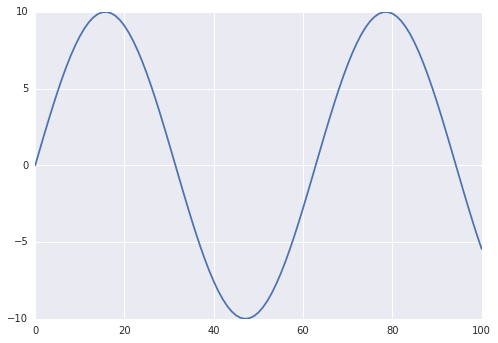

In [4]:
line_data = generate_data(10)
fig, ax = plt.subplots()
ax.plot(line_data.reshape(-1))
ax.grid(True)
ax.axis([0,100,-10,10])
plt.show()

In [5]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
labels_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchY_placeholder)

In [6]:
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [124]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
#predictions_series = [tf.nn.softmax(logits) for logits in logits_series]



#losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_series, labels=labels_series)]

losses = [tf.nn.l2_loss(labels - logits, name=None) for logits, labels in zip(logits_series,labels_series)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.1).minimize(total_loss)

In [125]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_list = []

x_data = generate_data(total_series_length)
_current_state = np.zeros(dtype=np.float32, shape=[1, 4])

for batch_idx in range(num_batches):
    start_idx = batch_idx
    end_idx = start_idx + truncated_backprop_length

    batchX = x_data[:,start_idx:end_idx]
    batchY = x_data[:,start_idx+1:end_idx+1]

    _total_loss, _train_step, _current_state = sess.run(
        [total_loss, train_step, current_state],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })

    loss_list.append(_total_loss)
    if batch_idx%1000 == 0:
        print("Step",batch_idx, "Loss", _total_loss)
        #print sess.run([labels_series], feed_dict={batchX_placeholder:batchX,batchY_placeholder:batchY,init_state:_current_state})
        #print sess.run([logits_series], feed_dict={batchX_placeholder:batchX,batchY_placeholder:batchY,init_state:_current_state})
        #print sess.run([losses], feed_dict={batchX_placeholder:batchX,batchY_placeholder:batchY,init_state:_current_state})

('Step', 0, 'Loss', 26.882999)
('Step', 1000, 'Loss', 0.13659917)
('Step', 2000, 'Loss', 0.081164226)
('Step', 3000, 'Loss', 0.039760862)
('Step', 4000, 'Loss', 0.042316698)
('Step', 5000, 'Loss', 0.072267577)
('Step', 6000, 'Loss', 0.034179732)
('Step', 7000, 'Loss', 0.029524554)
('Step', 8000, 'Loss', 0.036573783)
('Step', 9000, 'Loss', 0.023055373)


done
(1, 100)
(100,)


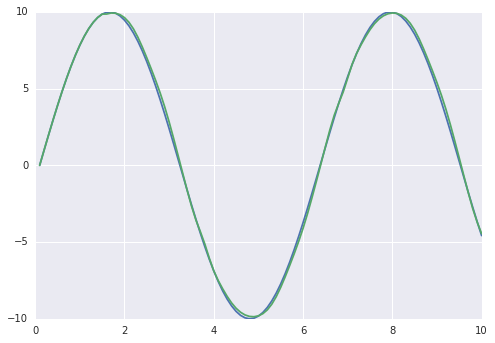

In [126]:
pred = Y = np.array([])
_current_state = np.zeros(dtype=np.float32, shape=[1, 4])
X = np.array([])

n = 0
for i in range(100):
    Y = np.append(Y, 10*np.sin(n)).reshape(1,-1)
    
    if i < 15:
        pred = np.append(pred, Y[:,-1])
        
    elif i >= 15:
        previous = np.array(Y[:,-16:-1])
        #print previous
        pred = np.append(pred, sess.run([logits_series[-1]], feed_dict={batchX_placeholder:previous, init_state:_current_state}))
        _current_state = sess.run(current_state, feed_dict={batchX_placeholder:previous, init_state:_current_state})
        
    #print Y.shape
    #print pred.shape
    
    n+= 0.1
    X = np.append(X, n)
    
print 'done'
print Y.shape
print pred.shape
Y = Y.reshape([-1])   
plt.plot(X,Y)
plt.plot(X,pred)
plt.show()